In [1]:
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppresses INFO (1), WARNING (2), and ERROR (3)
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from tabulate import tabulate
from termcolor import colored as cl
import random
from typing import List, Tuple, Dict, Optional
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import flwr as fl
from flwr.common import Context
from imblearn.over_sampling import SMOTE
from flwr.common import parameters_to_ndarrays
from flwr.common import ndarrays_to_parameters
from sdv.single_table import GaussianCopulaSynthesizer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import ray
import torch.nn as nn
import torch.nn.functional as F
from scipy.interpolate import make_interp_spline, interp1d

E0000 00:00:1744980527.707201    3465 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744980527.748555    3465 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-18 07:48:52,293	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/home/user/anaconda3/lib/python3.12/site-packages/rdt/transformers/utils.py:14: DeprecationWarning: module 'sre_parse' is deprecated
  import sre_parse  # isort:skip


In [212]:
NUM_CLIENTS = 10
LOCAL_EPOCHS_LIST= [5,5,5,5,5]
NUM_ROUNDS = 10

In [213]:
data = pd.read_csv('./EVSE_augmented_1.5.csv')

In [214]:
# # data.describe()
# !pip install Model

In [215]:
data.head()

,time,alarmtimer_alarmtimer_cancel,alarmtimer_alarmtimer_fired,alarmtimer_alarmtimer_start,alarmtimer_alarmtimer_suspend,alignment-faults,ase_spec,block_block_bio_backmerge,block_block_bio_bounce,block_block_bio_complete,...,writeback_writeback_wait_iff_congested,writeback_writeback_wake_background,writeback_writeback_write_inode,writeback_writeback_write_inode_start,writeback_writeback_written,ChargingState,Attack,Scenario,Label,interface
0,5.001477,0,0,0,0,0,693371795,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
1,5.001487,0,0,0,0,0,699964025,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
2,5.001641,0,0,0,0,0,549770341,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
3,5.003762,0,0,0,0,0,571970875,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
4,10.065740,0,0,0,0,0,553199786,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any


In [216]:
data["Label"].unique()

array(['attack', 'benign'], dtype=object)

In [217]:
cases = len(data)
benign_count = len(data[data.Label == "benign"])
attack_count = len(data[data.Label == "attack"])
anomolies_percentage = round(attack_count/cases*100, 2)

print(cl('CASE COUNT', attrs = ['bold']))
print(cl('--------------------------------------------', attrs = ['bold']))
print(cl('Total number of cases are {}'.format(cases), attrs = ['bold']))
print(cl('Number of Benign cases are {}'.format(benign_count), attrs = ['bold']))
print(cl('Number of attack cases are {}'.format(attack_count), attrs = ['bold']))
print(cl('Percentage of attack cases is {}'.format(anomolies_percentage), attrs = ['bold']))
print(cl('--------------------------------------------', attrs = ['bold']))

CASE COUNT
--------------------------------------------
Total number of cases are 12702
Number of Benign cases are 3454
Number of attack cases are 9248
Percentage of attack cases is 72.81
--------------------------------------------


In [218]:
data.duplicated().sum()

0

In [219]:
data = data.drop_duplicates()

In [220]:
total_rows = data.shape[0]
missing_columns = [col for col in data.columns if data[col].isnull().sum()>0]
for col in missing_columns:
  null_count = data[col].isnull().sum()
  per = (null_count/total_rows) * 100
  print(f"{col}: {null_count} ({round(per,3)}%)")

raw_syscalls_sys_enter: 2 (0.016%)
raw_syscalls_sys_exit: 3 (0.024%)
syscalls_sys_enter_arm64_personality: 5 (0.039%)
syscalls_sys_enter_capget: 4 (0.031%)
syscalls_sys_enter_capset: 2 (0.016%)
syscalls_sys_enter_clone: 3 (0.024%)
syscalls_sys_enter_clone3: 4 (0.031%)
syscalls_sys_enter_exit: 2 (0.016%)
syscalls_sys_enter_exit_group: 3 (0.024%)
syscalls_sys_enter_mmap: 2 (0.016%)
syscalls_sys_enter_rt_sigreturn: 3 (0.024%)
syscalls_sys_enter_set_tid_address: 3 (0.024%)
syscalls_sys_enter_unshare: 5 (0.039%)
syscalls_sys_enter_wait4: 2 (0.016%)
syscalls_sys_enter_waitid: 3 (0.024%)
syscalls_sys_exit_arm64_personality: 2 (0.016%)
syscalls_sys_exit_capget: 4 (0.031%)
syscalls_sys_exit_capset: 3 (0.024%)
syscalls_sys_exit_clone: 2 (0.016%)
syscalls_sys_exit_clone3: 3 (0.024%)
syscalls_sys_exit_exit: 3 (0.024%)
syscalls_sys_exit_exit_group: 2 (0.016%)
syscalls_sys_exit_mmap: 2 (0.016%)
syscalls_sys_exit_ptrace: 2 (0.016%)
syscalls_sys_exit_rt_sigreturn: 2 (0.016%)
syscalls_sys_exit_set_tid_

In [221]:
# Impute missing values using the mean for the specified columns
imputer = SimpleImputer(strategy='mean')

for col in missing_columns:
    data[col] = imputer.fit_transform(data[[col]])

data

,time,alarmtimer_alarmtimer_cancel,alarmtimer_alarmtimer_fired,alarmtimer_alarmtimer_start,alarmtimer_alarmtimer_suspend,alignment-faults,ase_spec,block_block_bio_backmerge,block_block_bio_bounce,block_block_bio_complete,...,writeback_writeback_wait_iff_congested,writeback_writeback_wake_background,writeback_writeback_write_inode,writeback_writeback_write_inode_start,writeback_writeback_written,ChargingState,Attack,Scenario,Label,interface
0,5.001477,0,0,0,0,0,693371795,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
1,5.001487,0,0,0,0,0,699964025,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
2,5.001641,0,0,0,0,0,549770341,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
3,5.003762,0,0,0,0,0,571970875,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
4,10.065740,0,0,0,0,0,553199786,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12697,3606.096204,0,0,0,0,0,314710680,2793,0,0,...,0,0,0,0,0,Charging,cryptojacking,Benign,attack,any
12698,1676.161152,0,0,0,0,0,225297323,3612,0,0,...,0,0,0,0,0,idle,cryptojacking,Benign,attack,none
12699,44.944882,0,0,0,0,0,44789343,3726,0,0,...,0,0,0,0,0,Charging,port-scan,DoS,attack,ocpp
12700,2645.700642,0,0,0,0,0,167412921,4291,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,benign,iso15118


In [222]:
def one_hot_encode(data):
    data = pd.get_dummies(data, columns=['ChargingState'], drop_first=True)
    return data

data = one_hot_encode(data)

def label_encode(data):
    for col in data.columns:
        if col == "Label":
            data["Label"] = data["Label"].map({'benign':0, 'attack':1})
        elif data[col].dtype == "object" and col != "ChargingState":
            data[col] = data[col].astype(str)
            label_encoder = LabelEncoder()
            data[col] = label_encoder.fit_transform(data[col])
    return data

data = label_encode(data)

data.head()

,time,alarmtimer_alarmtimer_cancel,alarmtimer_alarmtimer_fired,alarmtimer_alarmtimer_start,alarmtimer_alarmtimer_suspend,alignment-faults,ase_spec,block_block_bio_backmerge,block_block_bio_bounce,block_block_bio_complete,...,writeback_writeback_wait_iff_congested,writeback_writeback_wake_background,writeback_writeback_write_inode,writeback_writeback_write_inode_start,writeback_writeback_written,Attack,Scenario,Label,interface,ChargingState_idle
0,5.001477,0,0,0,0,0,693371795,0,0,0,...,0,0,0,0,0,2,1,1,0,False
1,5.001487,0,0,0,0,0,699964025,0,0,0,...,0,0,0,0,0,2,1,1,0,False
2,5.001641,0,0,0,0,0,549770341,0,0,0,...,0,0,0,0,0,2,1,1,0,False
3,5.003762,0,0,0,0,0,571970875,0,0,0,...,0,0,0,0,0,2,1,1,0,False
4,10.065740,0,0,0,0,0,553199786,0,0,0,...,0,0,0,0,0,2,1,1,0,False


In [223]:
scaler = StandardScaler()
X = scaler.fit_transform(data.drop('Label', axis=1))


In [224]:
# X_data = data.drop('Label', axis=1)
y= data['Label']


In [225]:
# X = Features, y = Labels (0=benign, 1=attack)
smote = SMOTE(sampling_strategy={0: 6166})  # Oversample benign (0) to match attack (1) count
X_balanced, y_balanced = smote.fit_resample(X, y)


In [226]:
# Data Split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)


In [227]:
def split_data_noniid(X, y, num_clients):
    # Convert to numpy arrays if needed
    X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
    y = y.to_numpy() if isinstance(y, pd.Series) else y


    benign_indices = np.where(y == 0)[0]
    attack_indices = np.where(y == 1)[0]


    np.random.shuffle(benign_indices)
    np.random.shuffle(attack_indices)


    total_attack = len(attack_indices)
    total_benign = len(benign_indices)
    total_samples = min(total_attack, total_benign) * 2  # Ensure 50-50 use


    # Truncate to balance
    attack_indices = attack_indices[:total_samples // 2]
    benign_indices = benign_indices[:total_samples // 2]


    # Define diverse per-client attack ratios (e.g., linearly spaced between 0.1 and 0.9)
    attack_ratios = np.linspace(0.1, 0.9, num_clients)


    # Compute sample counts for each client based on desired ratio
    client_datasets = []
    attack_cursor, benign_cursor = 0, 0
    attack_used, benign_used = 0, 0


    total_attack_remaining = len(attack_indices)
    total_benign_remaining = len(benign_indices)


    total_samples_per_client = total_samples // num_clients


    for i in range(num_clients):
        ratio = attack_ratios[i]
        num_attack = int(total_samples_per_client * ratio)
        num_benign = total_samples_per_client - num_attack


        # Make sure we don't go out of bounds
        if attack_cursor + num_attack > total_attack_remaining:
            num_attack = total_attack_remaining - attack_cursor
        if benign_cursor + num_benign > total_benign_remaining:
            num_benign = total_benign_remaining - benign_cursor


        client_attack = attack_indices[attack_cursor:attack_cursor + num_attack]
        client_benign = benign_indices[benign_cursor:benign_cursor + num_benign]


        attack_cursor += num_attack
        benign_cursor += num_benign


        client_indices = np.concatenate([client_attack, client_benign])
        np.random.shuffle(client_indices)


        client_datasets.append((X[client_indices], y[client_indices]))


    return client_datasets, attack_ratios


client_datasets, attack_ratios_used = split_data_noniid(X_train, y_train, num_clients=NUM_CLIENTS)


In [228]:
def reset_logfile():
    for cid in range(NUM_CLIENTS):
        log_file_accuracy = f"output/FedAvg2/client_{cid}_clients_{NUM_CLIENTS}.epochs_accuracy_FedAvg2.log"
        log_file_loss = f"output/FedAvg2/client_{cid}_clients_{NUM_CLIENTS}.epochs_loss_FedAvg2.log"
        if os.path.exists(log_file_accuracy):
            os.remove(log_file_accuracy)
        if os.path.exists(log_file_loss):
            os.remove(log_file_loss)
            

In [229]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [230]:
class FLClient(fl.client.NumPyClient):
    def __init__(self, model, train_data, local_epochs,cid):
        self.model = model
        self.train_data = train_data
        self.local_epochs = local_epochs
        self.cid = cid
   
    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        X, y = self.train_data
        self.model.fit(X, y, epochs=self.local_epochs, batch_size=32, verbose=0)
        return self.model.get_weights(), len(X), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        X, y = self.train_data
        loss, accuracy = self.model.evaluate(X, y, verbose=0)
    
        # Predictions and classification
        y_pred_probs = self.model.predict(X, verbose=0)
        y_pred = (y_pred_probs > 0.5).astype("int32")
    
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
    
        print(f"[Client {self.cid} Eval] Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    
        # Logging
        with open(f"output/FedAvg2/client_{self.cid}_clients_{NUM_CLIENTS}.epochs_accuracy_FedAvg2.log", "a") as f:
            f.write(f"{accuracy}\n")
        with open(f"output/FedAvg2/client_{self.cid}_clients_{NUM_CLIENTS}.epochs_loss_FedAvg2.log", "a") as f:
            f.write(f"{loss}\n")
    
        return loss, len(X), {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        }

In [231]:
def client_fn(cid: str):
    cid_int = int(cid)
    model = create_model()
    return FLClient(model, client_datasets[cid_int], LOCAL_EPOCHS_LIST[int(cid_int % 5)], cid)

In [232]:
def weighted_average(metrics):
    total_examples = sum(num_examples for num_examples, _ in metrics)

    # Initialize accumulators for each metric
    aggregated = {
        "accuracy": 0.0,
        "precision": 0.0,
        "recall": 0.0,
        "f1_score": 0.0
    }

    for num_examples, m in metrics:
        for key in aggregated:
            aggregated[key] += m[key] * num_examples

    # Final weighted average
    for key in aggregated:
        aggregated[key] /= total_examples

    return aggregated


In [233]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x.view(-1, 28 * 28)))
        return self.fc2(x)

In [234]:
model = Net()
initial_weights = [val.cpu().numpy() for _, val in model.state_dict().items()]
initial_parameters = ndarrays_to_parameters(initial_weights)

In [235]:
class ModelAggregrate(fl.server.strategy.FedAvg):
    def __init__(self, 
                 **kwargs):
        super().__init__(**kwargs)
        self.round_counter = 0
        self.final_weights = None

    def _add_noise(self, weights: List[np.ndarray]) -> List[np.ndarray]:
        return [w + np.random.normal(0, self.noise_scale*np.std(w), w.shape) 
                for w in weights]

    def aggregate_fit(self, server_round, results,  failures  ):
        self.round_counter  +=  1

        random.seed(server_round)
        np.random.seed(server_round)
        
        # Convert results and add noise
        weights_results  =  []
        for  client,  fit_res  in  results  :
            weights  =  fl.common.parameters_to_ndarrays(fit_res.parameters)
            
            weights_results.append((weights,fit_res.num_examples))
        
        # Standard FedAvg aggregation
        aggregated_weights  =  [
            np.average  (
                [w[i] for w,  _  in  weights_results],
                axis = 0,
                weights = [n for _, n in weights_results]
            )
            for i in range (len(weights_results[0][0]))
        ]
        
        if  aggregated_weights:
            self.final_weights = fl.common.ndarrays_to_parameters(aggregated_weights)  # Save for later use
            return  fl.common.ndarrays_to_parameters(aggregated_weights),  {}
        return  None,{}

# Usage
strategy  =  ModelAggregrate  (
    fraction_fit=0.8,
    min_fit_clients=int(NUM_CLIENTS * 0.8),
    min_available_clients  =  NUM_CLIENTS,
    evaluate_metrics_aggregation_fn  =  weighted_average,
)



In [236]:
reset_logfile()

history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    ray_init_args={"num_cpus": 8},  # Limits overall Ray CPU allocation
    client_resources={"num_cpus": 1},  # Ensures controlled task scheduling
    strategy=strategy,
)

ray.shutdown()

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2025-04-18 10:36:08,813	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 13129637070.0, 'object_store_memory': 6564818534.0, 'node:10.0.5.98': 1.0, 'node:__internal_head__': 1.0, 'CPU': 8.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 acto

(ClientAppActor pid=846280) [Client 1 Eval] Accuracy: 0.9200, Precision: 0.7801, Recall: 0.8011, F1: 0.7905


(ClientAppActor pid=846280) 
(ClientAppActor pid=846280)         
(ClientAppActor pid=846277) 
(ClientAppActor pid=846277)         
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 8 clients (out of 10)
(ClientAppActor pid=846280) 
(ClientAppActor pid=846280)         
(ClientAppActor pid=846277) 
(ClientAppActor pid=846277)         
(ClientAppActor pid=846282) 
(ClientAppActor pid=846282)         
(ClientAppActor pid=846275) 
(ClientAppActor pid=846275)         
(ClientAppActor pid=846278) 
(ClientAppActor pid=846278)         
(ClientAppActor pid=846279) 
(ClientAppActor pid=846279)         
(ClientAppActor pid=846281) 
(ClientAppActor pid=846281)         
(ClientAppActor pid=846276) 
(ClientAppActor pid=846276)         
INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=846279) 
(ClientApp

(ClientAppActor pid=846280) [Client 8 Eval] Accuracy: 0.9484, Precision: 0.9820, Recall: 0.9538, F1: 0.9677 [repeated 20x across cluster]


(ClientAppActor pid=846275) 
(ClientAppActor pid=846275)         
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 8 clients (out of 10)
(ClientAppActor pid=846279) 
(ClientAppActor pid=846279)         
(ClientAppActor pid=846281) 
(ClientAppActor pid=846281)         
(ClientAppActor pid=846275) 
(ClientAppActor pid=846275)         
(ClientAppActor pid=846277) 
(ClientAppActor pid=846277)         
(ClientAppActor pid=846276) 
(ClientAppActor pid=846276)         
(ClientAppActor pid=846278) 
(ClientAppActor pid=846278)         
(ClientAppActor pid=846280) 
(ClientAppActor pid=846280)         
(ClientAppActor pid=846282) 
(ClientAppActor pid=846282)         
INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=846280) 
(ClientAppActor pid=846280)         
(ClientAppActor pid=846279) 
(ClientApp

(ClientAppActor pid=846281) [Client 4 Eval] Accuracy: 0.9393, Precision: 0.9412, Recall: 0.9244, F1: 0.9327 [repeated 20x across cluster]


(ClientAppActor pid=846281) 
(ClientAppActor pid=846281)         
(ClientAppActor pid=846278) 
(ClientAppActor pid=846278)         
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 8 clients (out of 10)
(ClientAppActor pid=846280) 
(ClientAppActor pid=846280)         
(ClientAppActor pid=846281) 
(ClientAppActor pid=846281)         
(ClientAppActor pid=846278) 
(ClientAppActor pid=846278)         
(ClientAppActor pid=846279) 
(ClientAppActor pid=846279)         
(ClientAppActor pid=846275) 
(ClientAppActor pid=846275)         
(ClientAppActor pid=846277) 
(ClientAppActor pid=846277)         
(ClientAppActor pid=846276) 
(ClientAppActor pid=846276)         
(ClientAppActor pid=846282) 
(ClientAppActor pid=846282)         
INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=846280) 
(ClientApp

(ClientAppActor pid=846281) [Client 0 Eval] Accuracy: 0.9626, Precision: 0.7850, Recall: 0.8571, F1: 0.8195 [repeated 20x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 8 clients (out of 10)
(ClientAppActor pid=846279) 
(ClientAppActor pid=846279)         
(ClientAppActor pid=846279) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 14x across cluster]
(ClientAppActor pid=846279)             This is a deprecated feature. It will be removed [repeated 14x across cluster]
(ClientAppActor pid=846279)             entirely in future versions of Flower. [repeated 14x across cluster]
(ClientAppActor pid=846279) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to 

(ClientAppActor pid=846277) [Client 7 Eval] Accuracy: 0.9211, Precision: 0.9847, Recall: 0.9046, F1: 0.9430 [repeated 20x across cluster]


(ClientAppActor pid=846280) 
(ClientAppActor pid=846280)         
(ClientAppActor pid=846280) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 27x across cluster]
(ClientAppActor pid=846280)             This is a deprecated feature. It will be removed [repeated 27x across cluster]
(ClientAppActor pid=846280)             entirely in future versions of Flower. [repeated 27x across cluster]
(ClientAppActor pid=846280) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 27x across cluster]
(ClientAppActor pid=846280) 
(ClientAppActor pid=846280)         
(ClientAppActor pid=846279) 
(ClientAppActor pid=846279)      

(ClientAppActor pid=846277) [Client 9 Eval] Accuracy: 0.8831, Precision: 0.9987, Recall: 0.8718, F1: 0.9309 [repeated 10x across cluster]


(ClientAppActor pid=846277) 
(ClientAppActor pid=846277)         
(ClientAppActor pid=846280) 
(ClientAppActor pid=846280)         
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 42.32s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.2543806851199881
INFO :      		round 2: 0.18356003603528703
INFO :      		round 3: 0.17222820110724685
INFO :      		round 4: 0.16052233922959533
INFO :      		round 5: 0.14964712488115342
INFO :      		round 6: 0.148072936271501
INFO :      		round 7: 0.1420776142088833
INFO :      		round 8: 0.14123563133496994
INFO :      		round 9: 0.13101382502880884
INFO :      		round 10: 0.13973585085595558
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.8966180689424674),
INFO :      	              (2, 0.9155528582557101),
INFO :      	              (3, 0.9203118751675747),
INFO :      	              (4, 0.928918

(ClientAppActor pid=846277) [Client 2 Eval] Accuracy: 0.9646, Precision: 0.9614, Recall: 0.9088, F1: 0.9343 [repeated 9x across cluster]


In [153]:
# Model Save
final_model = create_model()
final_weight = parameters_to_ndarrays(strategy.final_weights)
final_model.set_weights(final_weight)
final_model.save("global_model_FedAvgM_Non_IID.h5")
print("Global model saved as 'global_model_FedAvgM_Non_IID.h5' ✅")

Global model saved as 'global_model_FedAvgM_Non_IID.h5' ✅


In [237]:

# Start with an empty DataFrame
metrics_df = pd.DataFrame()

# Go through each metric
for metric_name, round_values in history.metrics_distributed.items():
    # Convert list of (round, value) into DataFrame
    df = pd.DataFrame(round_values, columns=["round", metric_name])
    df.set_index("round", inplace=True)

    # Merge with main table
    metrics_df = pd.concat([metrics_df, df], axis=1)

# Optional: sort by round and round decimals
metrics_df = metrics_df.sort_index().round(4)

# Extract global loss values
global_loss = [loss for _, loss in history.losses_distributed]

# Add global_loss as the last column
metrics_df["loss"] = global_loss

# Reorder columns to ensure 'loss' is at the end
cols = [col for col in metrics_df.columns if col != "loss"] + ["loss"]
metrics_df = metrics_df[cols]

# Display the final DataFrame
metrics_df


,accuracy,precision,recall,f1_score,loss
round,,,,,
1,0.8966,0.9144,0.8297,0.8679,0.254381
2,0.9156,0.9338,0.8659,0.8969,0.183560
3,0.9203,0.8429,0.9453,0.8816,0.172228
4,0.9289,0.8649,0.9404,0.8941,0.160522
5,0.9348,0.9118,0.9138,0.9102,0.149647
6,0.9334,0.9472,0.8924,0.9180,0.148073
7,0.9371,0.9472,0.8988,0.9215,0.142078
8,0.9355,0.9561,0.8934,0.9227,0.141236
9,0.9430,0.9332,0.9188,0.9242,0.131014


In [185]:
print("\n[Global Accuracy Per Round]")
for rnd, (_, acc) in enumerate(history.metrics_distributed["accuracy"], start=1):
    print(f"Round {rnd}: {acc:.4f}")



[Global Accuracy Per Round]
Round 1: 0.8804
Round 2: 0.9062
Round 3: 0.9102
Round 4: 0.9145
Round 5: 0.9202
Round 6: 0.9274
Round 7: 0.9303
Round 8: 0.9327
Round 9: 0.9344
Round 10: 0.9363


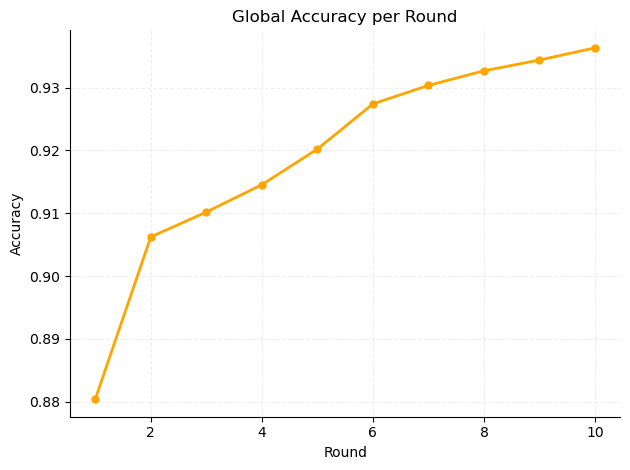

In [186]:
rounds = list(range(1, len(history.metrics_distributed["accuracy"]) + 1))
accuracies = [acc for _, acc in history.metrics_distributed["accuracy"]]

rounds_np = np.array(rounds)
accuracies_np = np.array(accuracies)

# Use linear interpolation instead of cubic spline
interpolator = interp1d(rounds_np, accuracies_np, kind='linear')
rounds_smooth = np.linspace(rounds_np.min(), rounds_np.max(), 100)
accuracies_smooth = interpolator(rounds_smooth)

fig, ax = plt.subplots(facecolor='white')  
ax.plot(rounds_smooth, accuracies_smooth, color='orange', linewidth=2)
ax.plot(rounds_np, accuracies_np, marker='.', linestyle='None', color='orange', markersize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Labels and grid
ax.set_title("Global Accuracy per Round")
ax.set_xlabel("Round")
ax.set_ylabel("Accuracy")
ax.grid(True, linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()


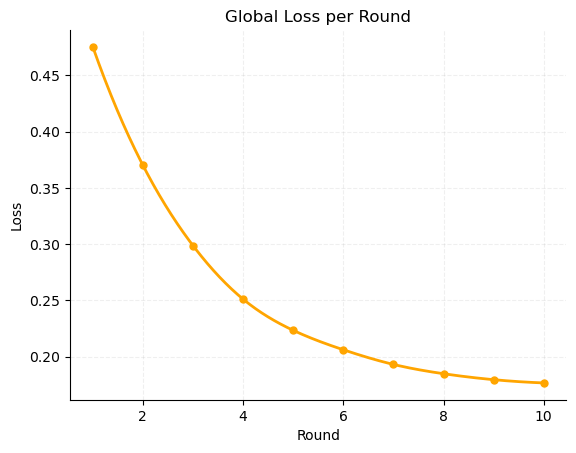

In [158]:
global_loss = [loss for _, loss in history.losses_distributed]
rounds = list(range(1, len(global_loss) + 1))

rounds_np = np.array(rounds)
losses_np = np.array(global_loss)

rounds_smooth = np.linspace(rounds_np.min(), rounds_np.max(), 300)
spline = make_interp_spline(rounds_np, losses_np, k=3)
losses_smooth = spline(rounds_smooth)

fig, ax = plt.subplots(facecolor='white')
ax.plot(rounds_smooth, losses_smooth, color='orange', linewidth=2)
ax.plot(rounds_np, losses_np, marker='.', linestyle='None', color='orange', markersize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title("Global Loss per Round")
plt.xlabel("Round")
plt.ylabel("Loss")
ax.grid(True, linestyle='--', alpha=0.2)
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))

for cid in range(NUM_CLIENTS):
    log_file = f"output/FedAvg2/client_{cid}_clients_{NUM_CLIENTS}.epochs_accuracy_FedAvg2.log"
    if os.path.exists(log_file):
        with open(log_file, "r") as f:
            accuracies = [float(line.strip()) for line in f.readlines()]
            plt.plot(range(1, len(accuracies)+1), accuracies, marker='o', label=f"Client {cid +1}")

plt.title("Client Accuracy per Round")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()